In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import log10 as lg
from numpy import pi as pi
from scipy.interpolate import interp1d as sp_interp1d
from scipy.integrate import odeint
from scipy.integrate import ode
import warnings
import timeit
import scipy.optimize as opt
from matplotlib import cm
from astropy import constants as const
from astropy import units as u

G=const.G.cgs.value
c=const.c.cgs.value
Ms=const.M_sun.cgs.value
hbar=const.hbar.cgs.value
m_n=const.m_n.cgs.value
km=10**5


In [2]:
# differential equation of angular velocity and quaternions
def wqdot(t, y):
    
    I1 = 1
    I2 = 2
    I3 = 3
    
    m= (y[3]**2 + y[4]**2 + y[5]**2 + y[6]**2 )**0.5
    y[3], y[4], y[5], y[6] =  y[3]/m, y[4]/m, y[5]/m, y[6]/m
    
    w1, w2, w3, q0, q1, q2, q3 = y[0], y[1], y[2], y[3], y[4], y[5], y[6]
    
    dydt=np.array([ (I2-I3) / I1 * w2 * w3, (I3-I1) / I2 * w3 * w1, (I1-I2) / I3 * w1 * w2, 1/2 * (-w1 * q1 - w2 * q2 - w3 * q3),
          1/2 * (w1 * q0 + w3 * q2 - w2 * q3), 1/2 * (w2 * q0 - w3 * q1 + w1 * q3), 1/2 * (w3 * q0 + w2 * q1 - w1 * q2)])

    return(dydt)

def initial(I1,I2,I3,w01,w02,w03):
    
   
    w1 = w01
    w2 = w02
    w3 = w03
    J=(I1**2*w1**2+I2**2*w2**2+I3**2*w3**2)**0.5
    J3=I3*w3
    theta0=np.arccos(J3/J)
    phi0=0
    psi0=pi/2
    
    q0 = np.cos(theta0 / 2) * np.cos((phi0 + psi0) / 2)
    q1 = np.sin(theta0 / 2) * np.cos((phi0 - psi0) / 2)
    q2 = np.sin(theta0 / 2) * np.sin((phi0 - psi0) / 2)
    q3 = np.cos(theta0 / 2) * np.sin((phi0 + psi0) / 2)
    
    return(np.array([w1, w2, w3, q0, q1, q2, q3]))

def rk4(t, h, y, f):
    h12 = h/2
    t12 = t + h12
    k1 = f(t,y)
    k2 = f(t12,y+h12*k1)
    k3 = f(t12,y+h12*k2)
    k4 = f(t+h,y+h*k3)
    return y + h*(k1+2*k2+2*k3+k4)/6


n=10000
h=13.8713/10000
y = np.zeros((n,7))
t = np.zeros(n)
t[0] = 0
y[0,:] =  initial(1,2,3,1,0,1)

for i in range(1,10000):
    
        y[i,:] = rk4(t[i-1], h, y[i-1,:], wqdot)
        
        t[i] = t[i-1]+h

In [3]:
sol=y
t=t

Text(0.5,0,'Time(s)')

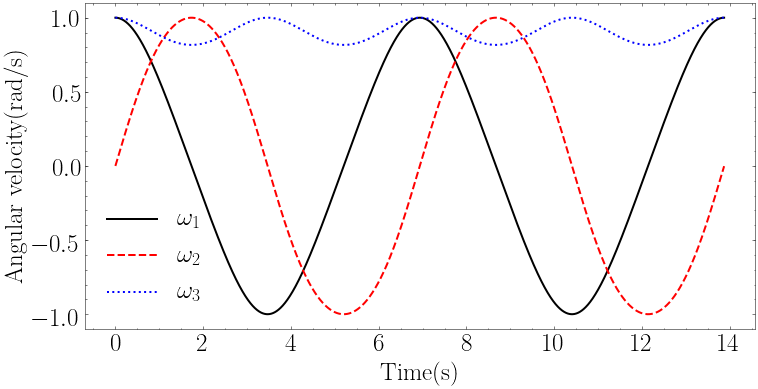

In [4]:
plt.figure(figsize=(12,6))
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.style.use(['science','ieee'])  

plt.plot(t, sol[:,0], label='$\omega_{1}$', linewidth=2)

plt.plot(t,sol[:,1], label='$\omega_{2}$', linewidth=2)

plt.plot(t,sol[:,2], label='$\omega_{3}$', linewidth=2)

plt.legend(fontsize=25)
plt.ylabel('Angular velocity(rad/s)',fontsize=25)
plt.xlabel('Time(s)',fontsize=25)

Text(0.5,0,'Time\\,[s]')

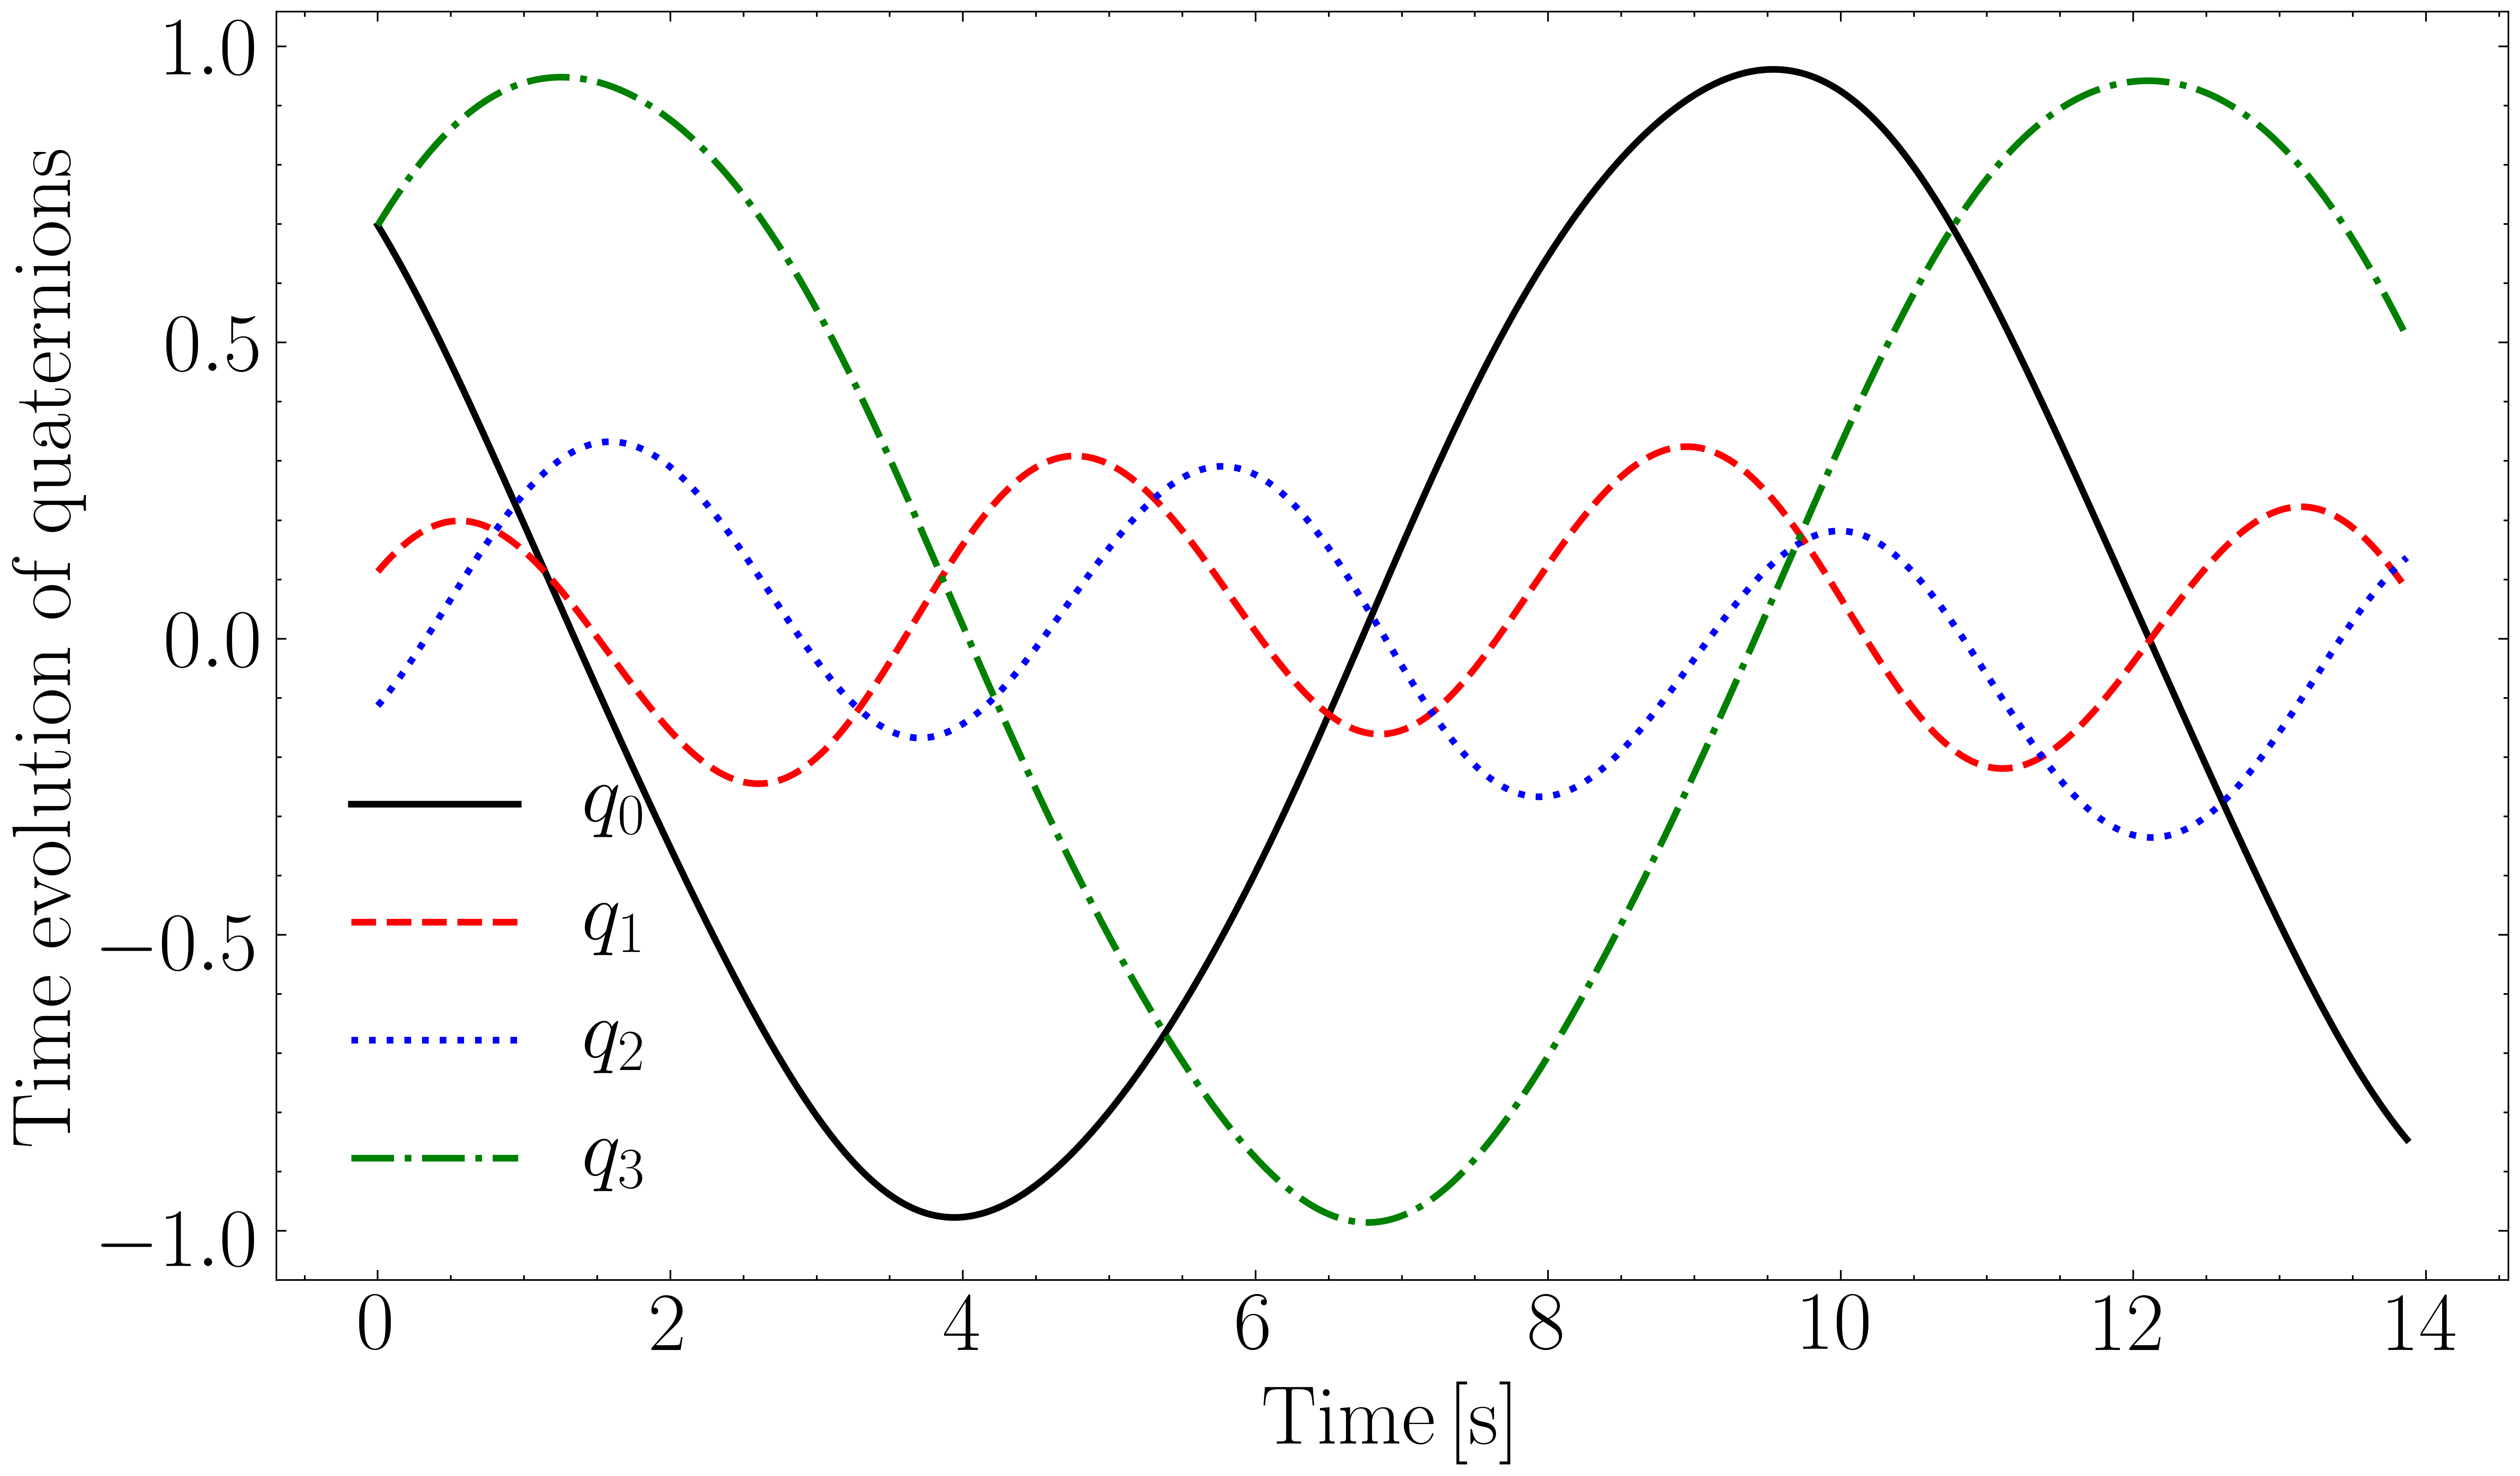

In [5]:
plt.figure(figsize=(12,7))
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.style.use(['science','ieee'])    

plt.plot(t, sol[:,3], label='$q_{0}$', linewidth=2)

plt.plot(t,sol[:,4], label='$q_{1}$', linewidth=2)

plt.plot(t,sol[:,5], label='$q_{2}$', linewidth=2)

plt.plot(t,sol[:,6], label='$q_{3}$', linewidth=2)

plt.legend(fontsize=25)
plt.ylabel('Time evolution of quaternions',fontsize=25)
plt.xlabel('Time\,[s]',fontsize=25)

Text(0,0.5,'$\\cos\\theta$')

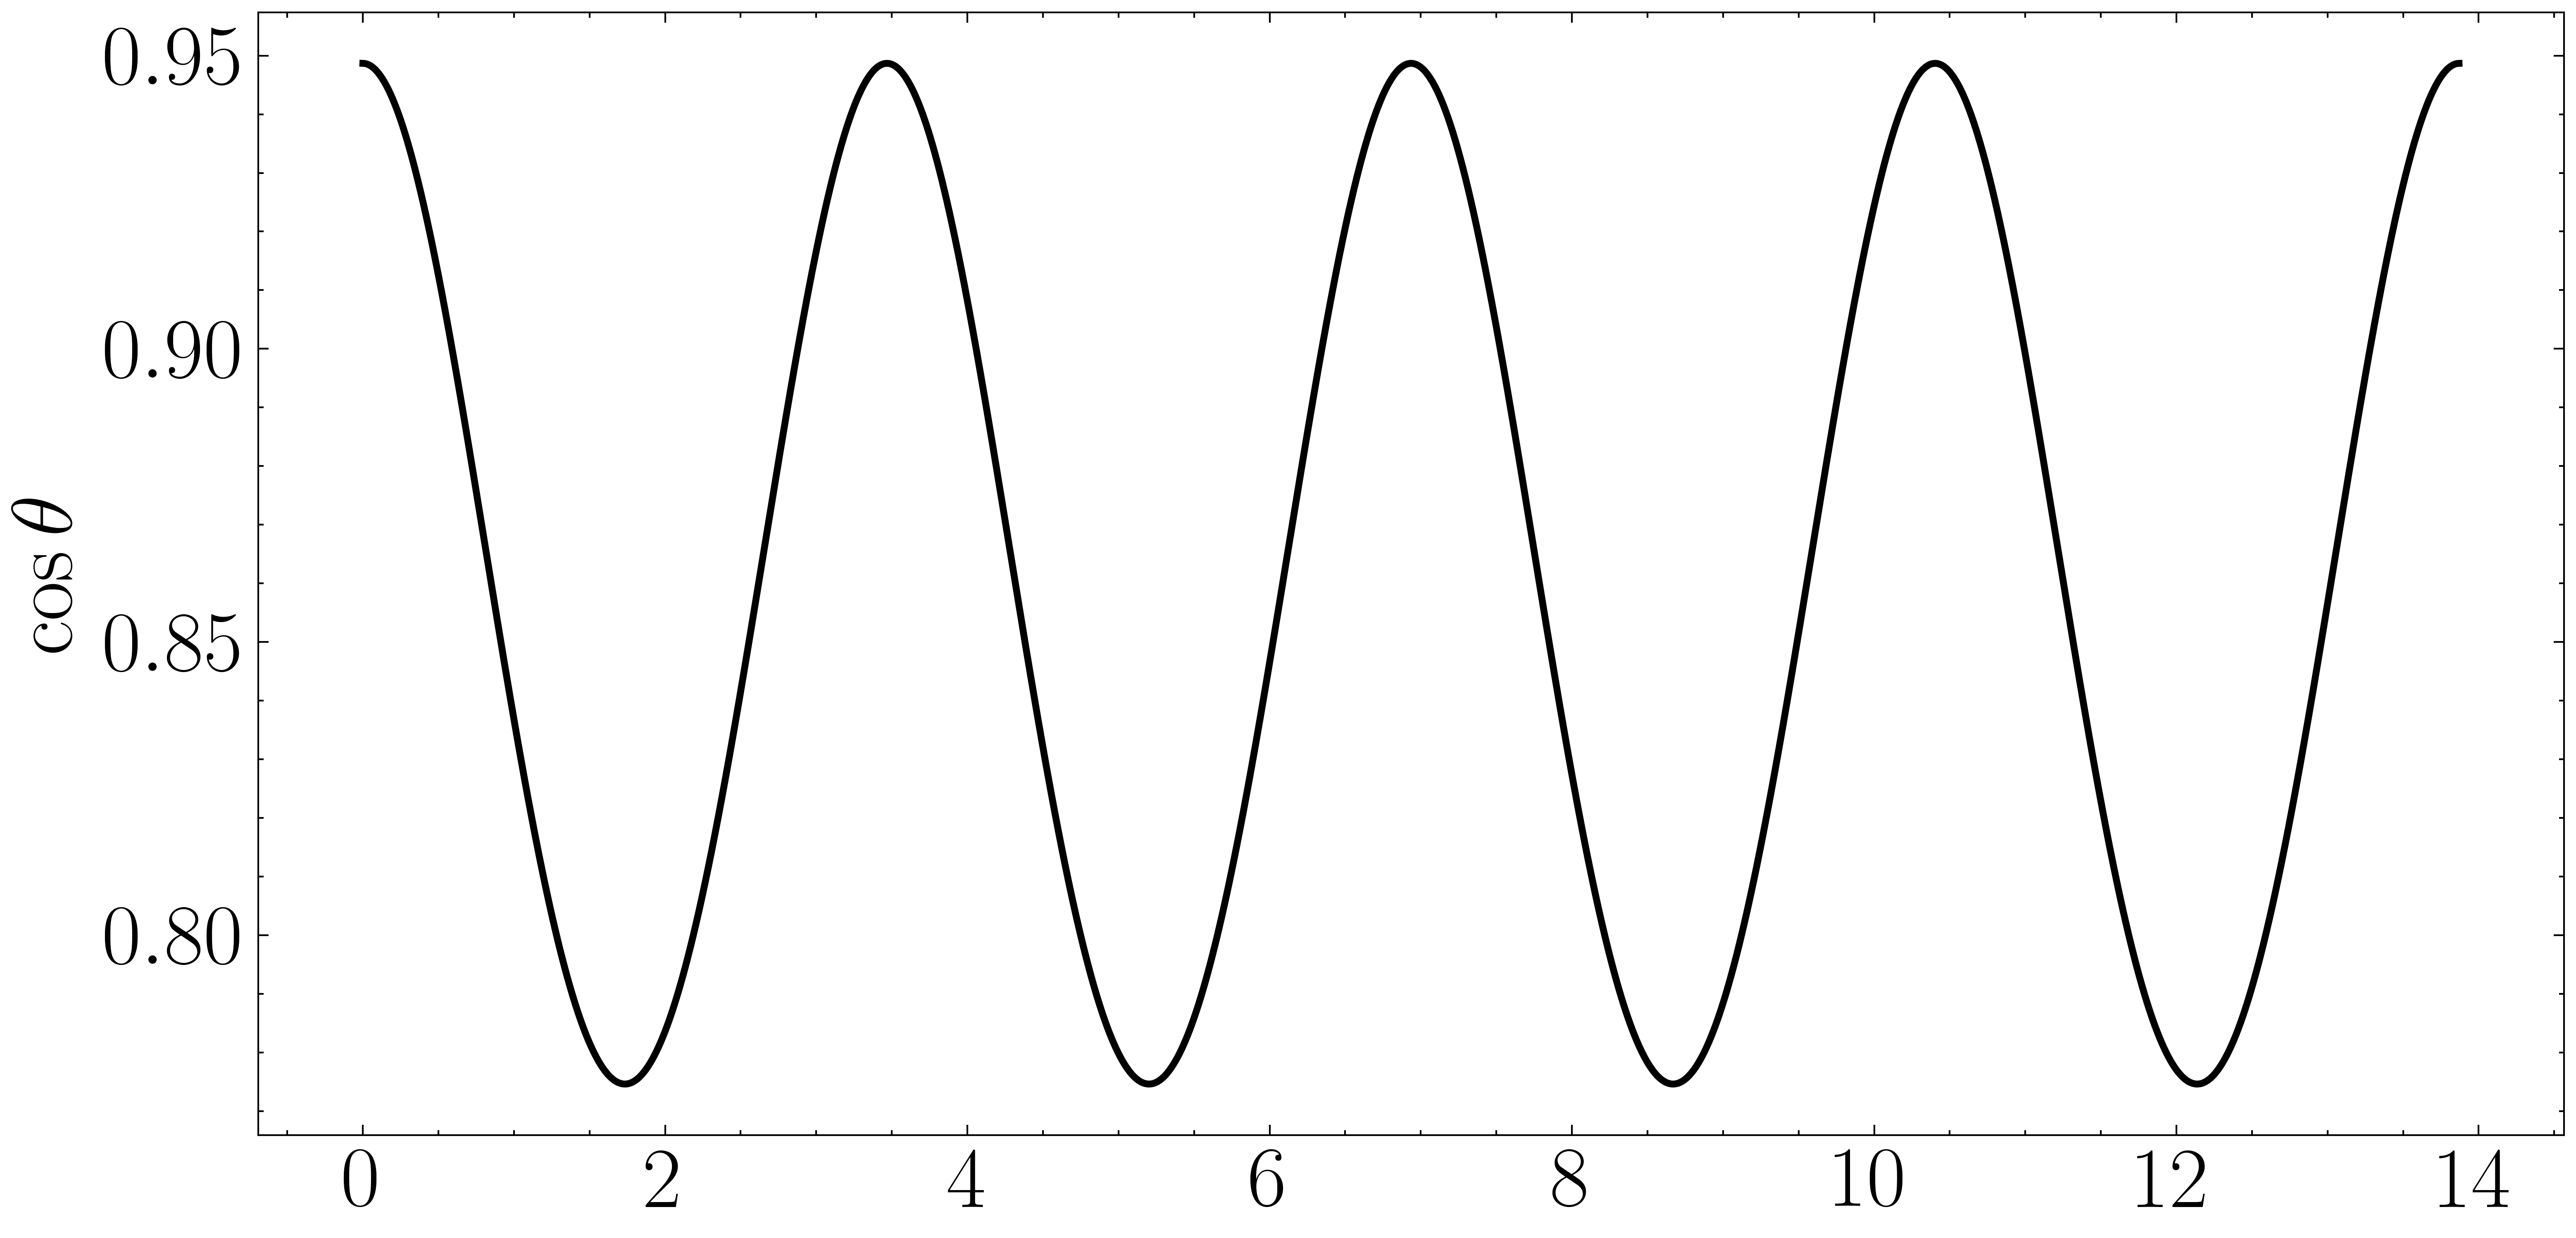

In [13]:
plt.figure(figsize=(12,6))
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
cos_theta=sol[:,3]**2 -sol[:,4]**2 -sol[:,5]**2 +sol[:,6]**2 

plt.plot(t,cos_theta, linewidth=2)
plt.ylabel(r'$\cos\theta$',fontsize=25)

Text(0,0.5,'$\\cos\\phi$')

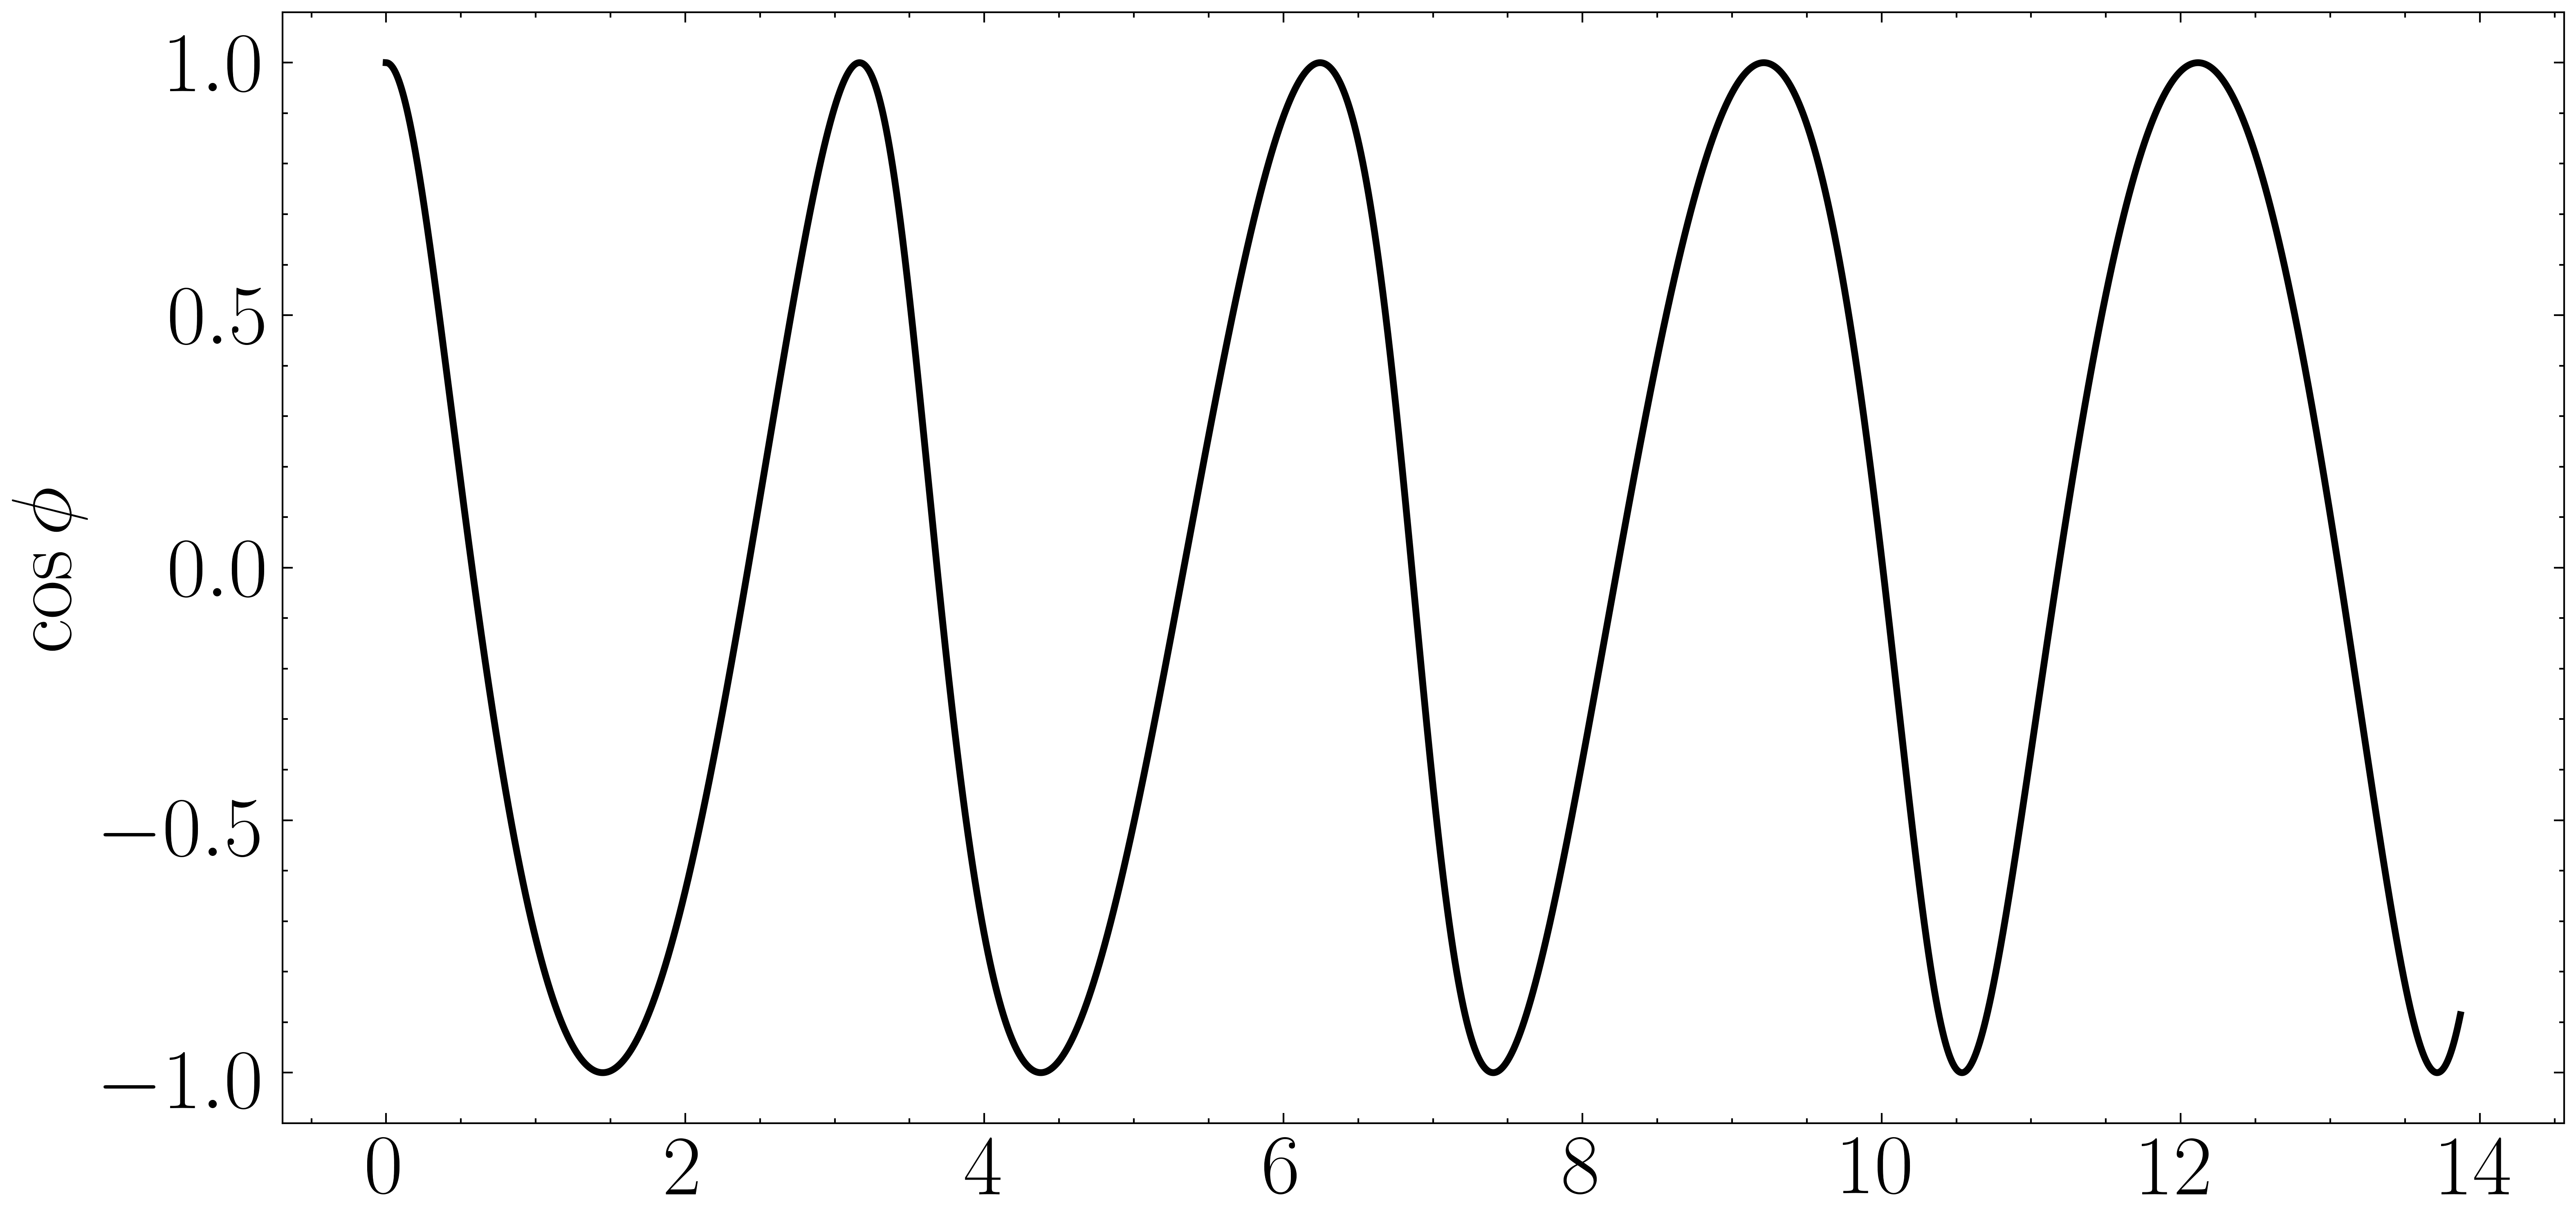

In [14]:
plt.figure(figsize=(12,6))
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
sin_theta=np.sin(np.arccos(cos_theta))
cos_phi=-2*(sol[:,5]*sol[:,6]-sol[:,3]*sol[:,4])/sin_theta
plt.plot(t,cos_phi, linewidth=2)
plt.ylabel(r'$\cos\phi$',fontsize=25)

Text(0,0.5,'$\\cos\\psi$')

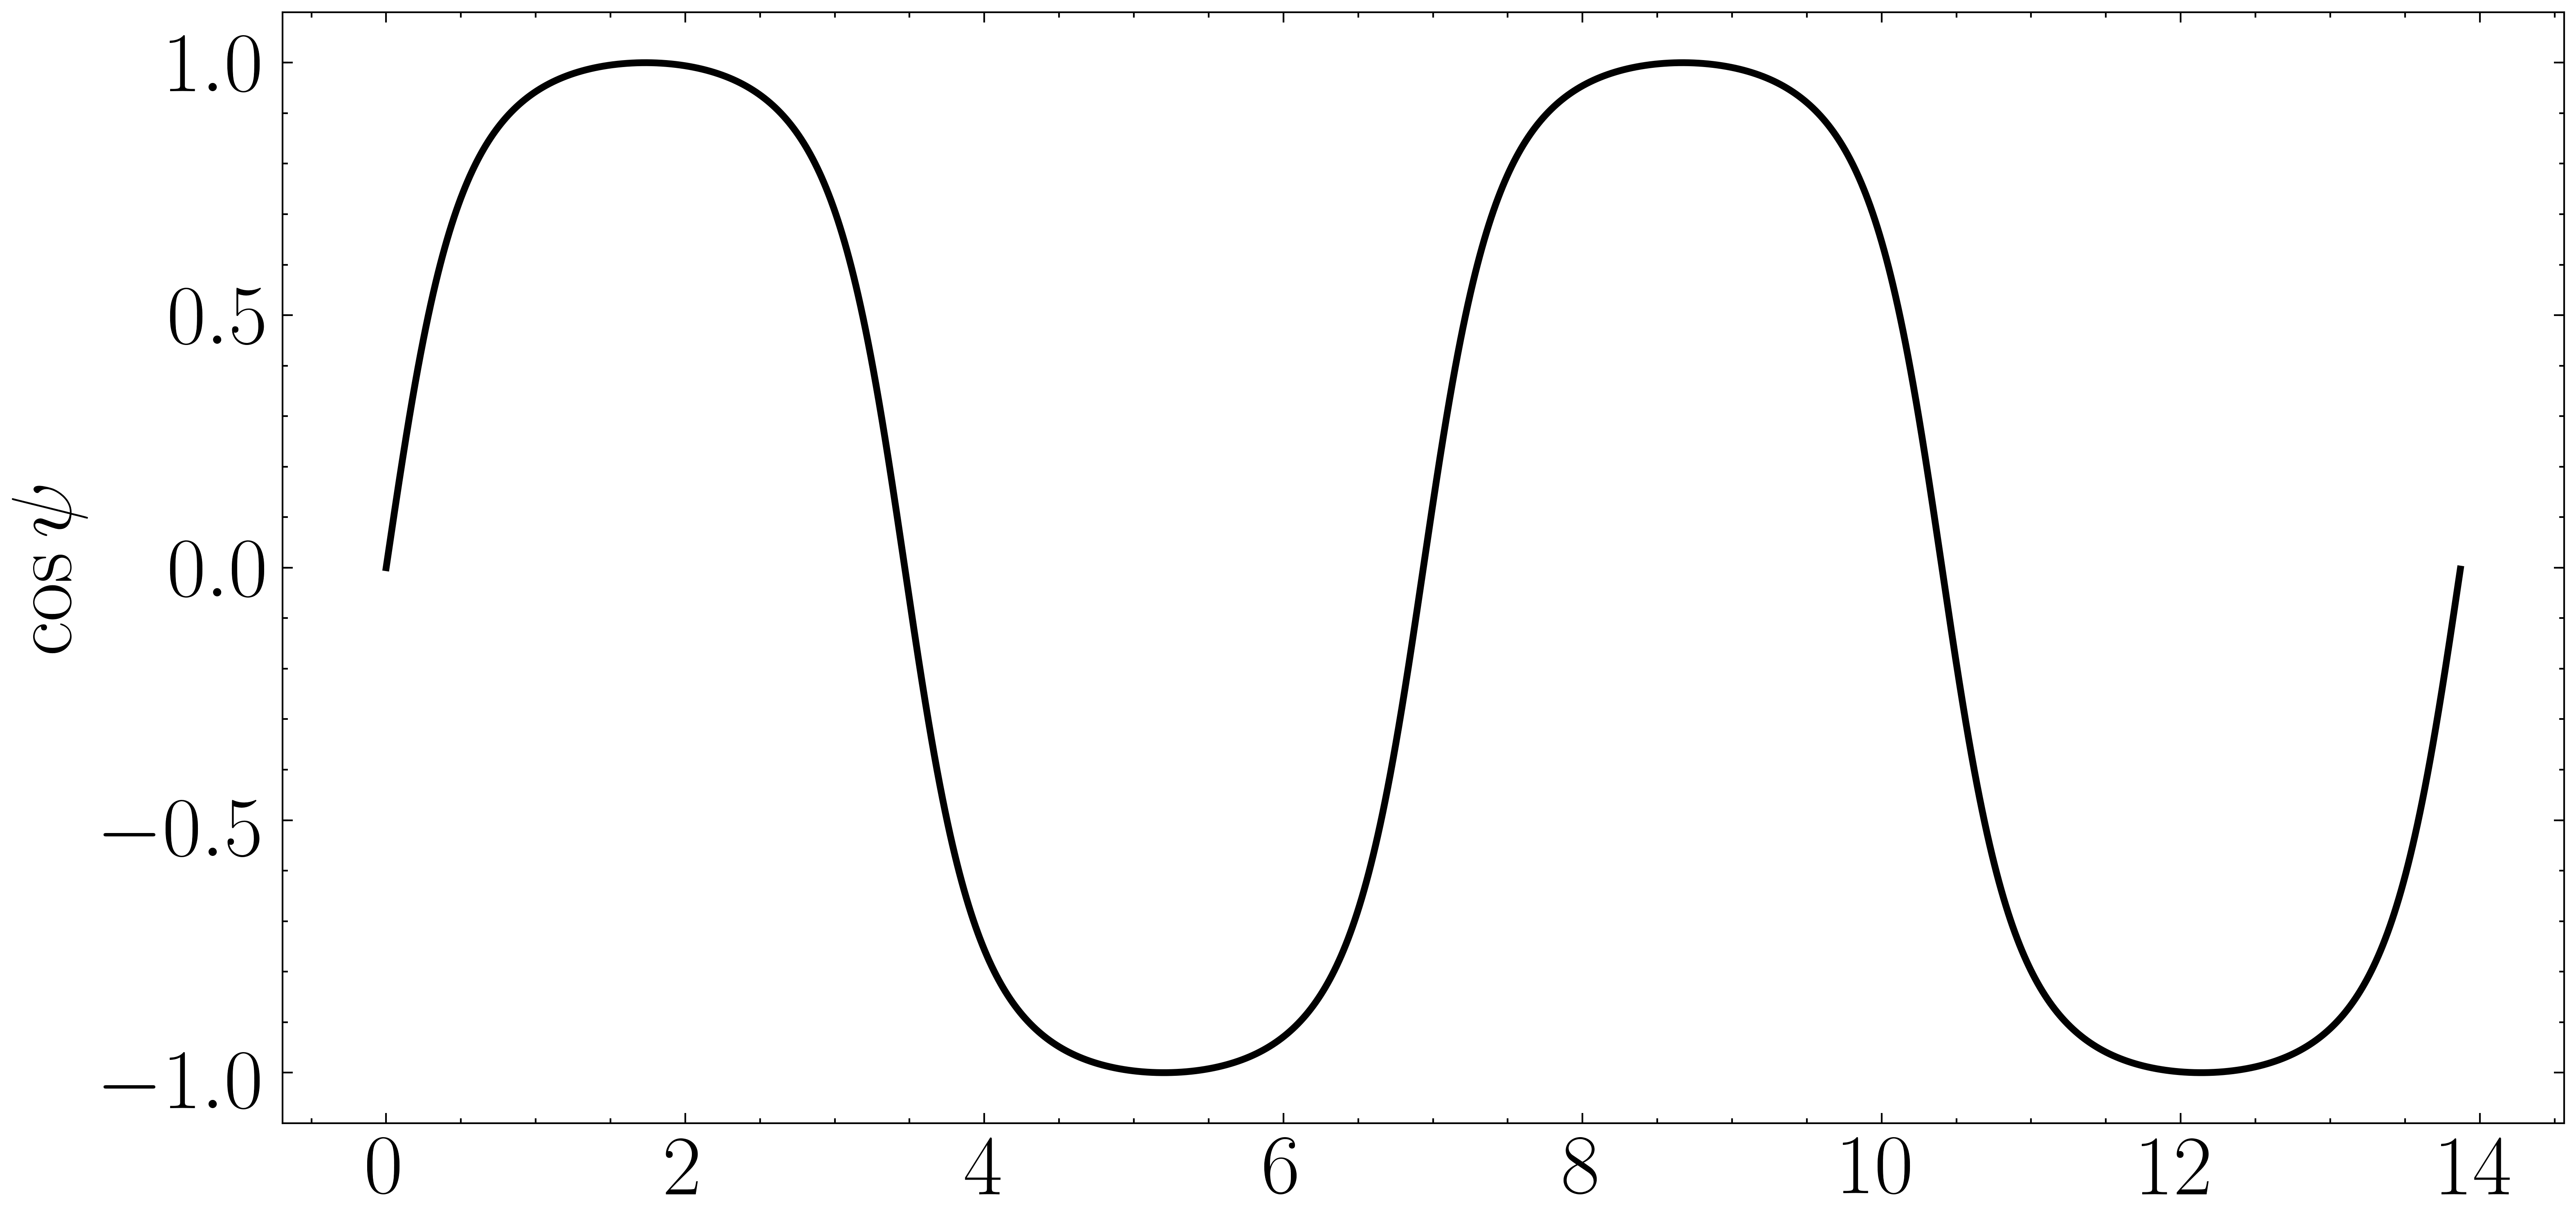

In [15]:
plt.figure(figsize=(12,6))
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
sin_theta=np.sin(np.arccos(cos_theta))
cos_phi=2*(sol[:,5]*sol[:,6]+sol[:,3]*sol[:,4])/sin_theta
plt.plot(t,cos_phi, linewidth=2)
plt.ylabel(r'$\cos\psi$',fontsize=25)

In [10]:
I1=1
I2=2
I3=3
d1=I2-I3
d2=I3-I1
d3=I1-I2
w1=sol[:,0]
w2=sol[:,1]
w3=sol[:,2]
A11 = 2*(d2*w2**2 - d3*w3**2)
A22 = 2*(d3*w3**2 - d1*w1**2)
A33 = 2*(d1*w1**2 - d2*w2**2)
A12 = (d1 - d2 + d3**2/ I3) *w1*w2
A21 = A12
A13 = (d3 - d1 + d2**2/ I2) *w1*w3
A31 = A13
A23 = (d2 - d3 + d1**2/I1) *w2*w3
A32 = A23

q0=sol[:,3]
q1=sol[:,4]
q2=sol[:,5]
q3=sol[:,6]

R11=q0**2+q1**2-q2**2-q3**2
R12=2*(q1*q2-q0*q3)
R13=2*(q1*q3+q0*q2)
R21=2*(q1*q2+q0*q3)
R22=q0**2-q1**2+q2**2-q3**2
R23=2*(q2*q3-q0*q1)
R31=2*(q1*q3-q0*q2)
R32=2*(q2*q3+q0*q1)
R33=q0**2-q1**2-q2**2+q3**2

In [11]:
cosi=np.cos(0)
sini=np.sin(0)
plus11 = ((cosi* R21 - sini* R31)*(cosi *R21 - sini* R31) -  R11*R11)*A11
plus12 = ((cosi* R21 - sini* R31)*(cosi *R22 - sini* R32) - R11*R12)*A12
plus13 = ((cosi* R21 - sini* R31)*(cosi *R23 - sini* R33) - R11*R13)*A13
plus21 = ((cosi* R22 - sini* R32)*(cosi *R21 - sini* R31) - R12*R11)*A21
plus22 = ((cosi* R22 - sini* R32)*(cosi* R22 - sini* R32) - R12*R12)*A22
plus23 = ((cosi* R22 - sini* R32)*(cosi *R23 - sini* R33) - R12*R13)*A23
plus31 = ((cosi *R23 - sini* R33)*(cosi *R21 - sini* R31) - R13*R11)*A31
plus32 = ((cosi* R23 - sini* R33)*(cosi*R22 - sini* R32) - R13*R12)*A32
plus33 = ((cosi *R23 - sini* R33)*(cosi *R23 - sini* R33) - R13*R13)*A33
hplus = - (plus11 + plus12 + plus13 + plus21 + plus22 + plus23 + plus31 + plus32 + plus33)

cross11 = (cosi* R21 - sini* R31)*R11 *A11
cross12 = (cosi* R21 - sini* R31)*R12 *A12
cross13 = (cosi* R21 - sini* R31)*R13 *A13
cross21 = (cosi* R22 - sini* R32)*R11 *A21
cross22 = (cosi* R22 - sini* R32)*R12 *A22
cross23 = (cosi*R22 - sini* R32)*R13 *A23
cross31 = (cosi* R23 - sini* R33)*R11 *A31
cross32 = (cosi* R23 - sini* R33)*R12 *A32
cross33 = (cosi* R23 - sini* R33)*R13 *A33
hcross = 2 *(cross11 + cross12 + cross13 + cross21 + cross22 +  cross23 + cross31 + cross32 + cross33)

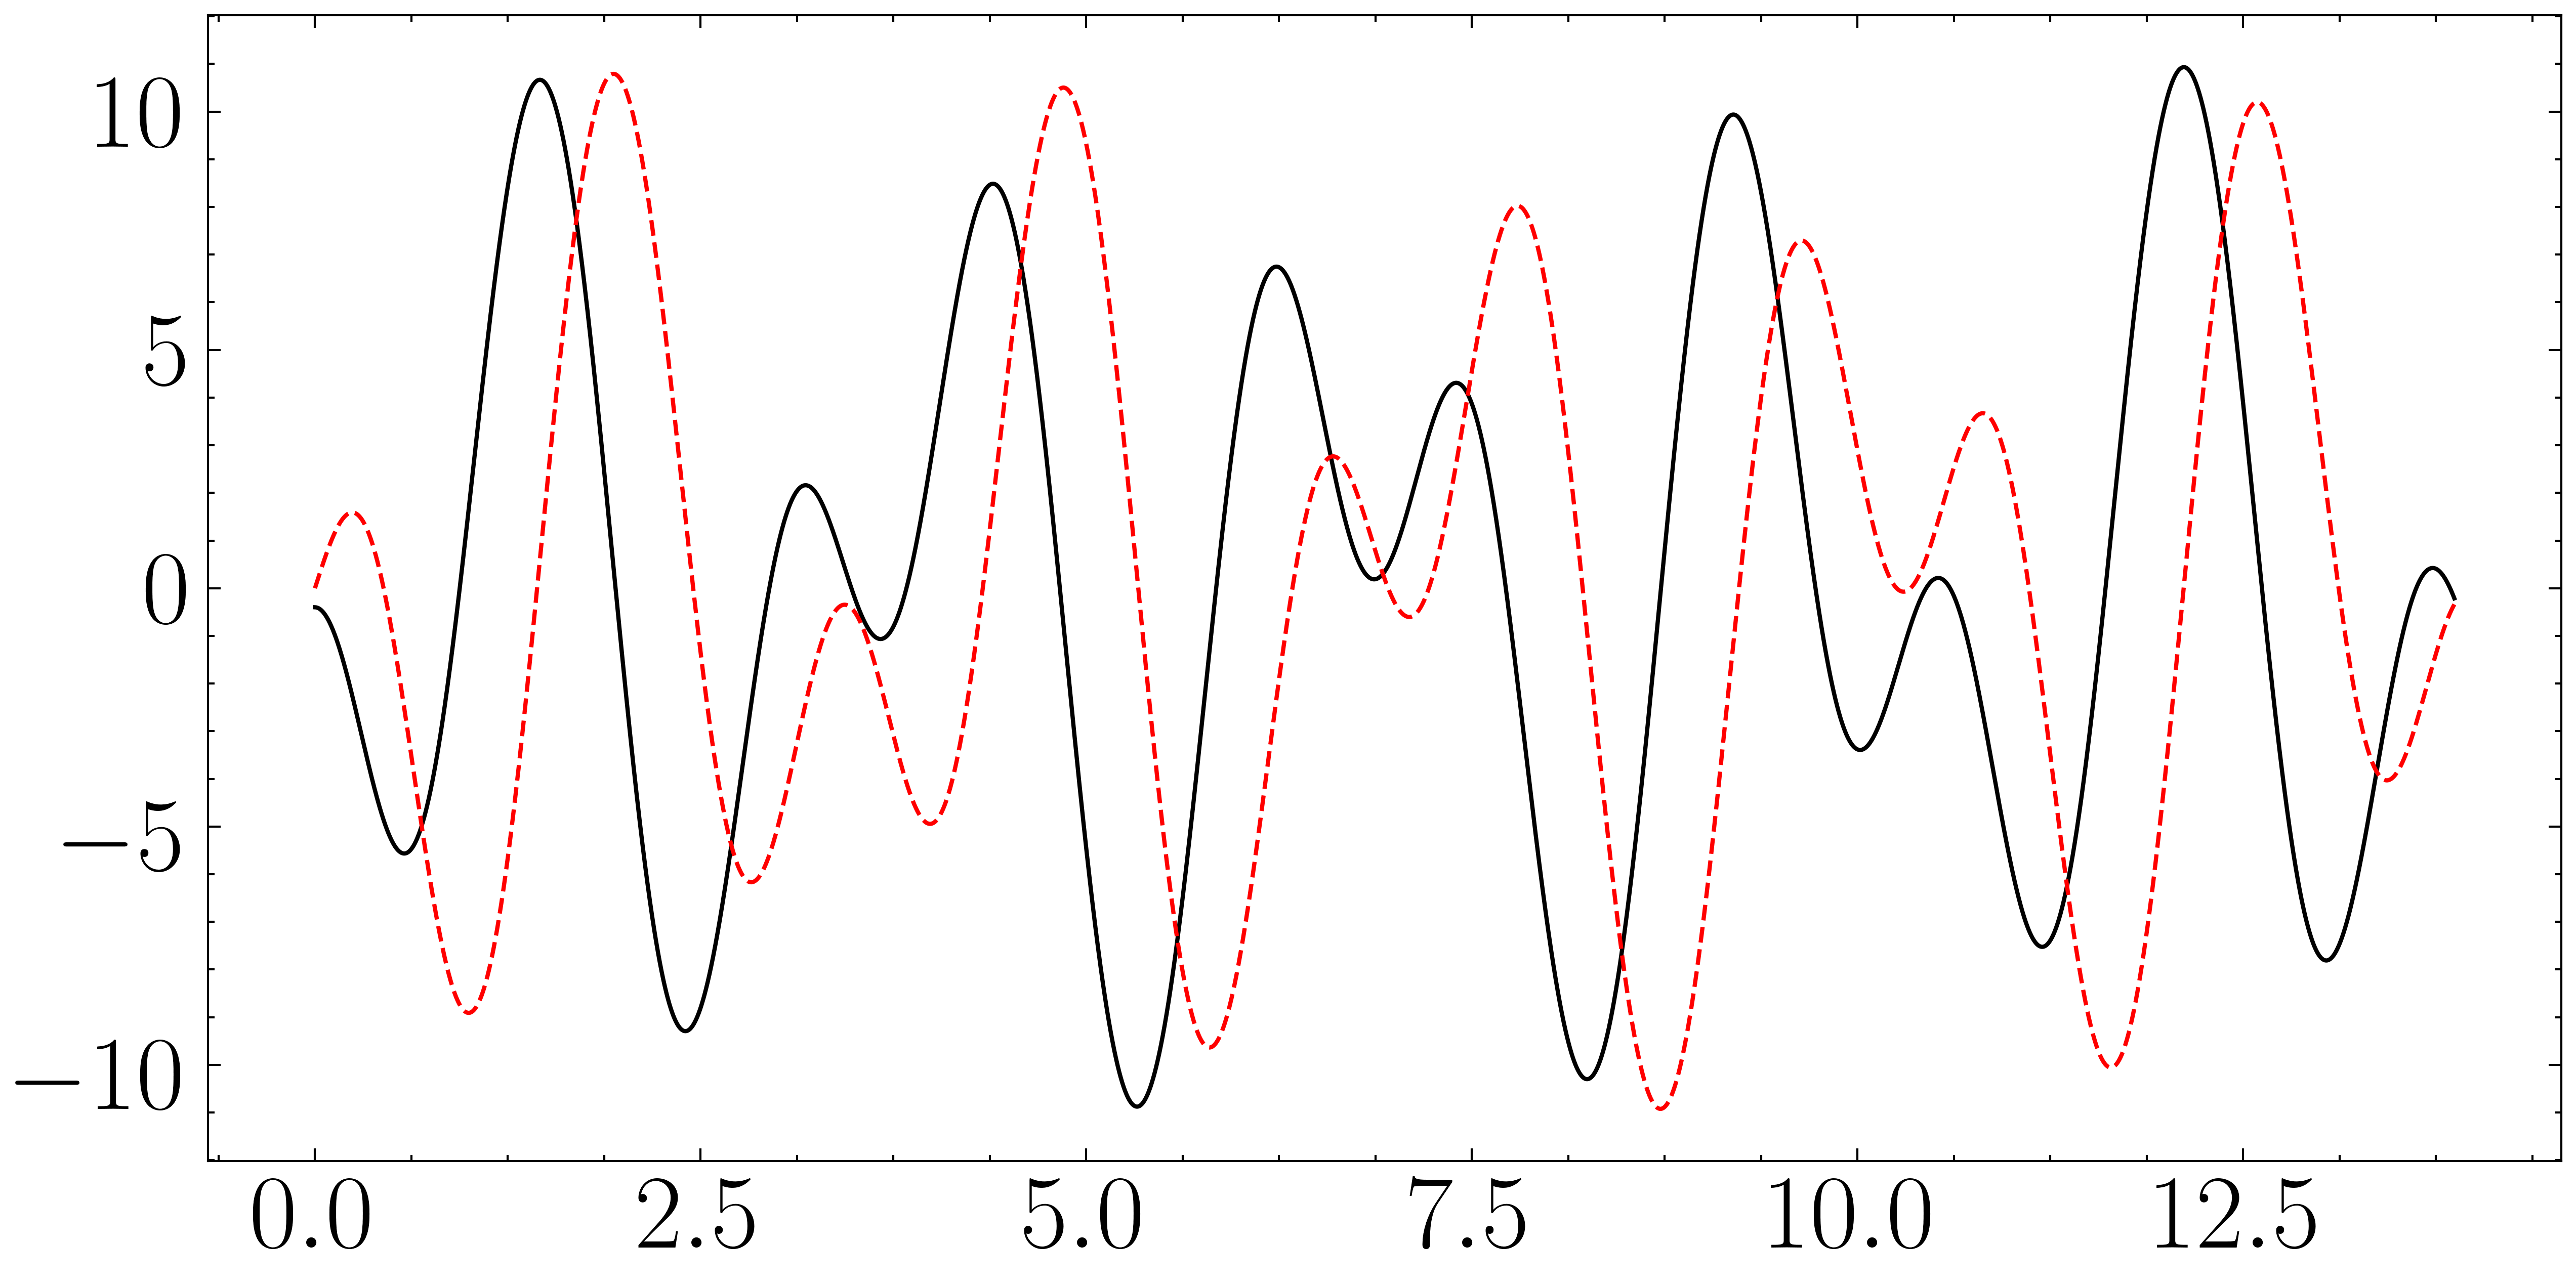

In [12]:
plt.figure(figsize=(10,5))
plt.plot(t,hplus)
plt.plot(t,hcross)